In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
count = 0
dirs = os.listdir(r'C:\Users\ASUS\Documents\dataset\Mobile Net\train')
for i in dirs:
    files = list(os.listdir(r'C:\Users\ASUS\Documents\dataset\Mobile Net\train' + '/' + i))
    count += len(files)
    print(i + ' punya ' + str(len(files)) + ' images')
print('Total gambar dalam folder: ', count)

jahe punya 100 images
kunyit punya 100 images
lengkuas punya 100 images
Total gambar dalam folder:  300


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = r"C:\Users\ASUS\Documents\dataset\Mobile Net\train"
validation_dir = r"C:\Users\ASUS\Documents\dataset\Mobile Net\validation"
test_dir = r"C:\Users\ASUS\Documents\dataset\Mobile Net\test" 

os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

categories = [name for name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, name))]

validation_split = 0.1  # 10% untuk validasi
test_split = 0.1        # 10% untuk test
train_split = 1 - validation_split - test_split  # 80% untuk train

for category in categories:
    category_dir = os.path.join(base_dir, category)
    validation_category_dir = os.path.join(validation_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    
    os.makedirs(validation_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)
    
    all_files = os.listdir(category_dir)
    
    train_val_files, test_files = train_test_split(all_files, test_size=test_split, random_state=42)
    
    train_files, val_files = train_test_split(train_val_files, test_size=validation_split / (train_split + validation_split), random_state=42)
    
    for file in val_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(validation_category_dir, file))
    
    for file in test_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(test_category_dir, file))

print("Dataset berhasil dibagi menjadi train, validation, dan test!")


Dataset berhasil dibagi menjadi train, validation, dan test!


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,          
    width_shift_range=0.3,     
    height_shift_range=0.3,   
    shear_range=0.3,          
    zoom_range=0.3,           
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    r'train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    r'validation',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    r'test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


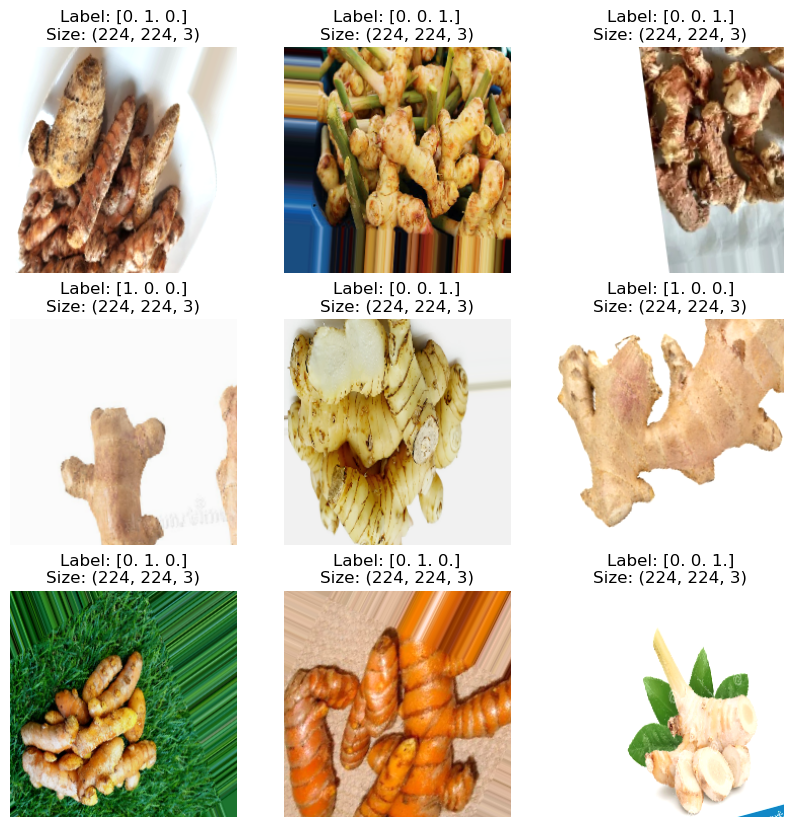

In [5]:
sample_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(sample_batch[0]))):
    image = sample_batch[0][i]
    label = sample_batch[1][i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}\nSize: {image.shape}")
    plt.axis('off')
plt.show()

In [6]:
def create_mobilenet_model(img_size, num_classes, depth_multiplier=1):
    model = Sequential()

    # Convolutional layers
    model.add(SeparableConv2D(int(32 * depth_multiplier), (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(int(32 * depth_multiplier), (1, 1), activation='relu', padding='same', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  

    model.add(DepthwiseConv2D((3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(int(64 * depth_multiplier), (1, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(DepthwiseConv2D((3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(int(128 * depth_multiplier), (1, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(DepthwiseConv2D((3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(int(256 * depth_multiplier), (1, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(GlobalAveragePooling2D())
    model.add(Dense(int(512 * depth_multiplier), activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2'))
    model.add(Dropout(0.7))
    model.add(Dense(num_classes, activation='softmax')) 

    return model

In [7]:
model = create_mobilenet_model(img_size=224, num_classes=3)

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 28, 28, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 182,974 (714.74 KB)

 Trainable params: 181,502 (708.99 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [10]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,        
    restore_best_weights=True
)


In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 64,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 64,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.2958 - loss: 12.9285 - val_accuracy: 0.3333 - val_loss: 11.6155 - learning_rate: 1.0000e-04
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3125 - loss: 12.6263

c:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.3125 - loss: 12.6263 - val_accuracy: 0.3333 - val_loss: 11.6076 - learning_rate: 1.0000e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.2569 - loss: 12.3980 - val_accuracy: 0.3333 - val_loss: 11.5847 - learning_rate: 1.0000e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.3281 - loss: 12.0828 - val_accuracy: 0.3333 - val_loss: 11.5770 - learning_rate: 1.0000e-04
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3846 - loss: 12.1493 - val_accuracy: 0.3333 - val_loss: 11.5530 - learning_rate: 1.0000e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.3438 - loss: 12.2243 - val_accuracy: 0.3333 - val_loss: 11.5449 - learning_rate: 1.0000e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.4116 - loss: 12.1452 - val_accuracy: 0.3333 - val_loss: 11.5199 - learning_rate: 1.0000e-04
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - accuracy: 0.4375 - loss: 11.9

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - accuracy: 0.3333 - loss: 10.7570
Test Loss: 10.75701904296875
Test Accuracy: 0.3333333432674408


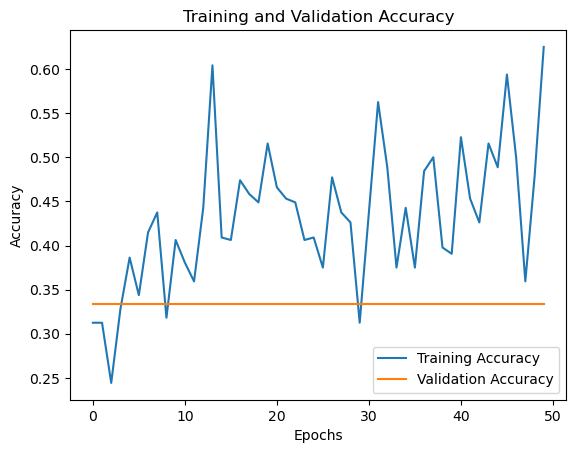

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

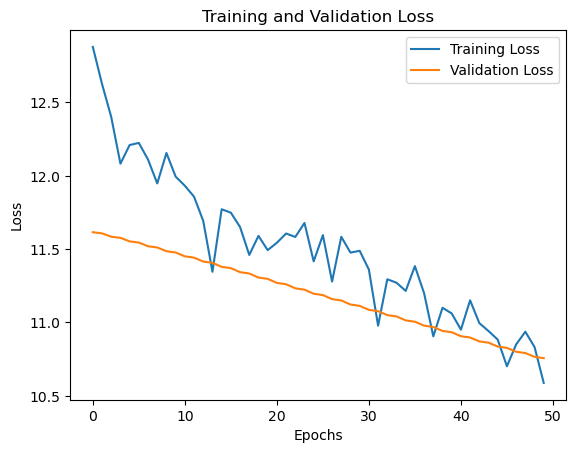

In [15]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
model.save('BestModel_MobileNet_AlbertCornelius.h5')

Found 30 images belonging to 3 classes.


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 10.7570
Test Loss: 10.75701904296875
Test Accuracy: 0.3333333432674408
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


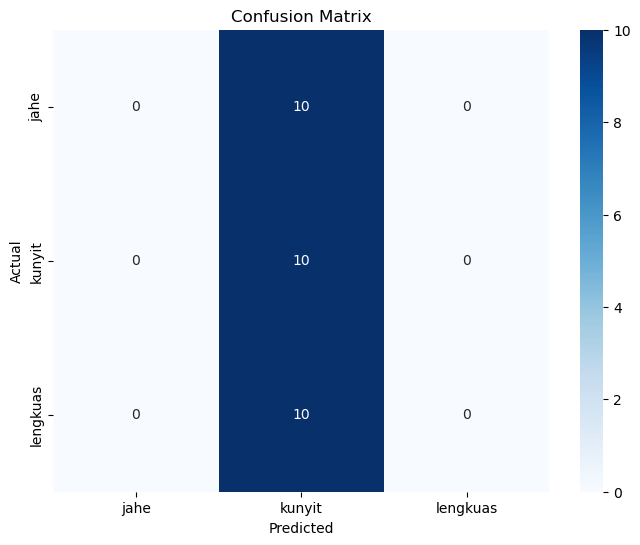

Classification Report:
              precision    recall  f1-score   support

        jahe       0.00      0.00      0.00        10
      kunyit       0.33      1.00      0.50        10
    lengkuas       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    r'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

model = load_model('BestModel_MobileNet_AlbertCornelius.h5')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)
